## Alt-Clinic (COVID-19 data)

Please continue reading if you (alternatively) would like to work with the recent COVID-19 data. The data (per country) are provided **daily** via this GitHub repository https://github.com/CSSEGISandData/COVID-19.

You are going to follow a similar approach as above, but adapted using the following steps:

* Start by exploring the plot of the COVID-19 cases (in total) and justify the exponential rate of increase
* Proper visualizations of the timeseries

Obviously, one interesting task is to compare how new infection cases appear in different countries and if there is a similarity in the evolution of these timeseries, i.e. can we assume that the timeseries evolution of infections in the Netherlands will have the same evolution as in e.g. China or Italy?

* Provide commentary on the problems that arise from the selection bias introduced by different ways that countries handle reporting. If you find fit, do some research into how countries do tests and how do they report their cases

* Provide commentary (and eventually a solution) of the "start day problem" of the timeseries: The problem is that while in China the outbreak was already in January, in Italy it was in late February and in the Netherlands is not quite yet determined(?). Define your "day 0" properly: If you look online, some people consider as day 0, either the day that the country reported the first infection, or the day that a cummulative amount of e.g. 50 infections were reported, or you might think of something else. The reason for this is to have a proper comparison metric for the timeseries of different countries.

* Pick some countries (incl. Netherlands) and visualize the results on this "shifted"/"normalized" time-scale

* Report preliminary results on the visual inspection of the plots

And now for the most challenging task, let's try to predict! The real challenge here is that we don't have enough data points for having accurate train/test models, so you have to think of a work-around (e.g. fit model for a deep-in-the-outbreak-country like China and then try to see how that model performs on other countries).

Here are some steps to follow:

* Try to fit an ARIMA model for predicting the evolution of the infected cases worldwide
* Try to fit an ARIMA model for a specific country (e.g. China).
* Use this guide (http://people.duke.edu/~rnau/arimrule.htm) as indicative rules for which model fits the best
* As the situation evolves and since the clinic is delivered in one week, you can use "real" world data for testing! Make sure to download the data every day and check your model prediction.
* Show your predictions in a plot
* Evaluate your models using MAE, MSE and R-squared

Since this is "extra-ordinary" conditions, let me(us) know how we can help you more into this or if you have any other cool idea. 

Stay healthy and enjoy!

### Ideas
* stationarize?
* correlogram


In [2]:
import IPython.core.display
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (18, 6)
matplotlib.rcParams['lines.linewidth'] = 1
sns.set(style="ticks")
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
path = "data/time_series_19-covid-"
confirmed = pd.read_csv(path+"Confirmed.csv",keep_default_na=False)
deaths = pd.read_csv(path+"Deaths.csv",keep_default_na=False)
recovered = pd.read_csv(path+"Recovered.csv",keep_default_na=False)

In [4]:
dfs = [confirmed, deaths,recovered]

In [5]:
colors = ['y','r','g']

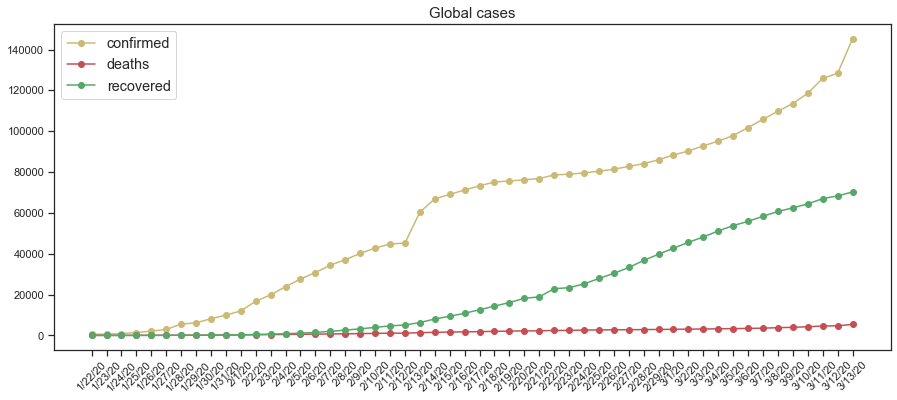

In [8]:
plt.figure(figsize=(15, 6))
for i,df in enumerate(dfs):
    total_cases = df.iloc[:,4:].sum()
    plt.plot(total_cases.index,total_cases.values,'-o'+colors[i])
plt.xticks(rotation=45)
plt.legend(labels=['confirmed','deaths','recovered'],loc='upper left',fontsize='x-large')
plt.title('Global cases',fontsize=15)
plt.show()

From [Wikipedia](https://en.wikipedia.org/wiki/Exponential_growth) (aka The Most Reliable and Academic Source Possible &trade;): "Exponential growth is a specific way that a quantity may increase over time. It occurs when the instantaneous rate of change (that is, the derivative) of a quantity with respect to time is proportional to the quantity itself."

Furthermore, as presented by [3Blue1Brown](https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be), we can model the rate of change of covid-19 cases in the following manner:
#### $\Delta N_d = E \cdot p \cdot N_d$
where:
* $N_d$ - number of cases on a given day
* $E$ - avg. number of people that are exposed to an infected person each day
* $p$ - probability of each exposure becoming an infection

In plain English:
* the more people are in contact with infected people, the faster the number of cases increases (this is why social distancing is so important)
* the higher the probability of an exposure becoming an infection, the faster the number of cases increases (this why taking prevention measures, such as washing hands more often, is so important)
* and finally, the higher the number of cases, the faster the number of cases increases ($\Delta N_d$ is proportional to $N_d$)

The last bullet point proves that we are dealing with an exponential growth (by definition).